# Brief problem description 
Link to competition: https://dacon.io/competitions/official/235591/overview/ 

The primary aim of this contest is to predict the amount of rainfall given satellite information. Thus we are dealing with a regression problem. The provided train data is a condensed version of the GPM (global precipitation measurement) core satellite data provided by NASA. https://pmm.nasa.gov/gpm seems to contain more information on GPM. 

Also, the full train and test data can be downloaded from this public google drive link: https://drive.google.com/drive/folders/14EHxvp_Nc7iFE0CBuF6Bz6GxtFUOXLBL. An exaplanation of the dataset is provided in https://dacon.io/competitions/official/235591/talkboard/400589 slide 8, or in this video https://dacon.io/competitions/official/235591/talkboard/400598 starting in sections 7:50 and 15:00. 

Essentially, the GPM satellites provide (mainly) two information: one from a sensor called GMI (GPM Microwave Imager) and another from a sensor called DPR (Dual Frequency Precipitation Radar). Both of theses are sensors on the GPM satellites. **We want to predict results of the DPR given data from the GMI. So the microwave images are the features and the precipitation is the label (something we want to predict)**. The reason why we want to be able to predict results from the DPR sensor instead of actually getting observations from the DPR sensor is because it has narrow bandwidth and cannot predict the full extent of the data covered by the GMI. Watch this https://dacon.io/competitions/official/235591/talkboard/400598 starting 8:20 to get a clearer explanation. 

### A bit more about GPM (from my shallow research) 
The GPM program uses 9 satellites and each satellite contains microwave sensors. Apparently, the microwave reflected from the Earth reacts with the water molecules in the atmosphere and we get data by observing this phenomenon (or the **brightness** caused by the microwave interacting with water molecules in the atmosphere). See slide 3 from this link: https://dacon.io/competitions/official/235591/talkboard/400589    


In [2]:
import numpy as np
import pandas as pd
import PIL
from PIL import Image
import cv2
import os
import matplotlib.pyplot as plt

Let's first read in the train data 

In [5]:
train_dir = './train/' 
train_files = [train_dir + x for x in os.listdir(train_dir)]

In [35]:
print(len(train_files)) 
train_sample = np.load(train_files[15]) # just randomly took some sample 
print(train_sample.shape) 

76345
(40, 40, 15)


As we can see, there are 76345 training data and each data is of dimension 40x40x15. So there are 15 channels in total, where each channel is of dimension 40x40. Each channel represents the following information: brightness0,brightness1,..,brightness8,indicator type (지표타입), GMI Longitude (경도), GMI Latitude (위도),DPR Longitude (경도), DPR Latitude (위도), Precipitation (mm/h). The explanation of the data can be viewed here: https://dacon.io/competitions/official/235591/data/ under the data section. 

In [8]:
test_dir = './test/' 
test_files = [test_dir + x for x in os.listdir(test_dir)] 
test_sample = np.load(test_files[0]) 
print(test_sample.shape)

(40, 40, 14)


We see that one channel is missing for each of the test data (14 channels instead of 15) because we need to predict the precipitation for each of the test samples. 


Let's try to visualize the training data. From what I know, the first 9 channels (from 0 to 8) are the brightness detected by the GMI. Let's try to print these brightness channels as images. 

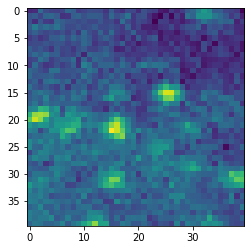

In [95]:
plt.imshow(train_sample[:,:,0]) 
plt.show()

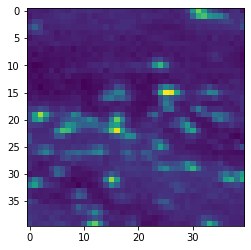

In [96]:
plt.imshow(train_sample[:,:,5]) 
plt.show()

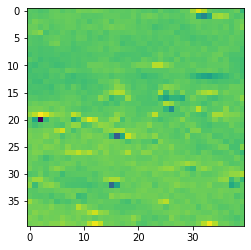

In [97]:
plt.imshow(train_sample[:,:,7]) 
plt.show()

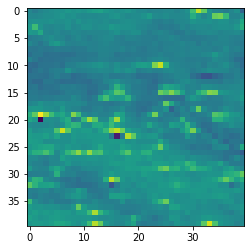

In [98]:
plt.imshow(train_sample[:,:,8]) 
plt.show()

For the brightness data, each pixel represents the temperature. Now, let's try and look at a sample precipitation image. 

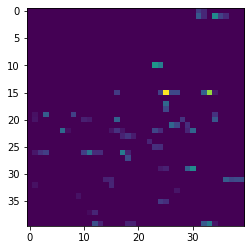

In [99]:
plt.imshow(train_sample[:,:,14])
plt.show()

Let's look at the precipitation data for another sample 

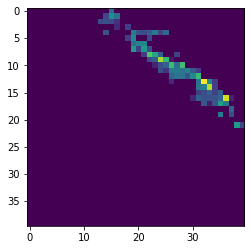

In [100]:
train_sample2 = np.load(train_files[100]) 
plt.imshow(train_sample2[:,:,14])
plt.show()

In [109]:
train_sample3 = np.load(train_files[120]) 
train_sample3[:,:,14]

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [21.19002342, 21.19002342, 21.19002342, ...,  3.29143405,
         0.47390664,  0.28147343],
       [12.53909492, 12.53909492, 12.53909492, ...,  0.34647959,
         0.3707158 ,  0.27223057],
       [ 4.42280293,  4.42280293,  4.42280293, ...,  0.68790817,
         0.24807893,  0.21949118]])

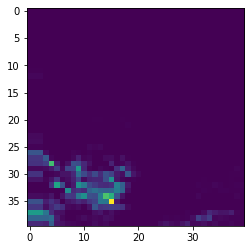

In [110]:
plt.imshow(train_sample3[:,:,14]) 
plt.show()

We see slightly brighter pixels in regions where precipitation values are 21.19,12.539,... etc. 

# Submission 
In order to submit for this competition, we have to make a prediction for the test data and save the prediction as csv and submit this single csv file. Below is the sample submission format 

In [202]:
df = pd.read_csv('./sample_submission.csv') 
df.head()

,id,px_1,px_2,px_3,px_4,px_5,px_6,px_7,px_8,px_9,...,px_1591,px_1592,px_1593,px_1594,px_1595,px_1596,px_1597,px_1598,px_1599,px_1600
0,029858_01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,029858_02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,029858_03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,029858_05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,029858_07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Because the precipitation data is 40x40, we need to predict the precipitation for each of the 1600 pixels and organize them in the format like above. The evaluation metric (scoring method) is described here: https://dacon.io/competitions/official/235591/overview/. They use the mean absolute error divided by the F1 Score.

Let's try a simple linear regression for test submission (just because it is simple to implement - I am not claiming that there exists a linear relationship between the feature and the label). I will use a simple algorithm to submit a test linear regression model 

1. For each data, take the average of the brightness for the 9 microwave images 
2. Fit 1600 linear regression models  
3. Predicting using 1600 models   

The code below is really rough and messy, but hopefully it passes for submission. 

In [245]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression 

X = [] 
Y = [] 
for i in range(1600): 
    X.append([]) 
    Y.append([])  
    
models = [] 

# pre-process data 
process_cnt = 1 
for path in train_files[:10000]:  
    print("processing data {}........".format(process_cnt))
    data = np.load(path) 
    d_X = np.zeros(1600)
    for i in range(0,9): 
        x = data[:,:,i].reshape(-1,1600)    
        x = x.flatten() 
        d_X = np.add(d_X,x)
    d_X = d_X/9.0   
    d_Y = data[:,:,14].reshape(-1,1600).flatten()  
    for i in range(0,1600):    
        X[i].append(d_X[i]) 
        Y[i].append(d_Y[i])   
    process_cnt = process_cnt+1 

    
fit_cnt = 1 
# fit model 
for i in range(0,1600):    
    print("fitting model {}........".format(fit_cnt))
    regr = LinearRegression() 
    X[i] = np.asarray(X[i]).reshape(-1,1)   
    Y[i] = np.asarray(Y[i]).reshape(-1,1)  
    regr.fit(X[i],Y[i]) 
    models.append(regr)  
    fit_cnt = fit_cnt+1 
    

#print(models[0].intercept_) 
#print(models[0].coef_[0])
    
predictions = [] 

# make prediction  
for path in test_files:  
    data = np.load(path) 
    d_X = np.zeros(1600) 
    for i in range(0,9): 
        x = data[:,:,i].reshape(-1,1600).flatten() 
        d_X = np.add(d_X,x) 
    d_X = d_X/9.0    
    prediction = [] 
    for i in range(1600):   
        p = models[i].intercept_ + d_X[i] * models[i].coef_[0]   
        prediction.append(p[0]) 
    predictions.append(prediction)

    
submission = pd.DataFrame(predictions)  
submission.insert(0,"id",df['id'],True) 
submission.columns = df.columns 
submission.to_csv('test_submission.csv',index=False) 
submission.head(10)

processing data 1........
processing data 2........
processing data 3........
processing data 4........
processing data 5........
processing data 6........
processing data 7........
processing data 8........
processing data 9........
processing data 10........
processing data 11........
processing data 12........
processing data 13........
processing data 14........
processing data 15........
processing data 16........
processing data 17........
processing data 18........
processing data 19........
processing data 20........
processing data 21........
processing data 22........
processing data 23........
processing data 24........
processing data 25........
processing data 26........
processing data 27........
processing data 28........
processing data 29........
processing data 30........
processing data 31........
processing data 32........
processing data 33........
processing data 34........
processing data 35........
processing data 36........
processing data 37........
processing

processing data 316........
processing data 317........
processing data 318........
processing data 319........
processing data 320........
processing data 321........
processing data 322........
processing data 323........
processing data 324........
processing data 325........
processing data 326........
processing data 327........
processing data 328........
processing data 329........
processing data 330........
processing data 331........
processing data 332........
processing data 333........
processing data 334........
processing data 335........
processing data 336........
processing data 337........
processing data 338........
processing data 339........
processing data 340........
processing data 341........
processing data 342........
processing data 343........
processing data 344........
processing data 345........
processing data 346........
processing data 347........
processing data 348........
processing data 349........
processing data 350........
processing data 351.

processing data 629........
processing data 630........
processing data 631........
processing data 632........
processing data 633........
processing data 634........
processing data 635........
processing data 636........
processing data 637........
processing data 638........
processing data 639........
processing data 640........
processing data 641........
processing data 642........
processing data 643........
processing data 644........
processing data 645........
processing data 646........
processing data 647........
processing data 648........
processing data 649........
processing data 650........
processing data 651........
processing data 652........
processing data 653........
processing data 654........
processing data 655........
processing data 656........
processing data 657........
processing data 658........
processing data 659........
processing data 660........
processing data 661........
processing data 662........
processing data 663........
processing data 664.

processing data 936........
processing data 937........
processing data 938........
processing data 939........
processing data 940........
processing data 941........
processing data 942........
processing data 943........
processing data 944........
processing data 945........
processing data 946........
processing data 947........
processing data 948........
processing data 949........
processing data 950........
processing data 951........
processing data 952........
processing data 953........
processing data 954........
processing data 955........
processing data 956........
processing data 957........
processing data 958........
processing data 959........
processing data 960........
processing data 961........
processing data 962........
processing data 963........
processing data 964........
processing data 965........
processing data 966........
processing data 967........
processing data 968........
processing data 969........
processing data 970........
processing data 971.

processing data 1247........
processing data 1248........
processing data 1249........
processing data 1250........
processing data 1251........
processing data 1252........
processing data 1253........
processing data 1254........
processing data 1255........
processing data 1256........
processing data 1257........
processing data 1258........
processing data 1259........
processing data 1260........
processing data 1261........
processing data 1262........
processing data 1263........
processing data 1264........
processing data 1265........
processing data 1266........
processing data 1267........
processing data 1268........
processing data 1269........
processing data 1270........
processing data 1271........
processing data 1272........
processing data 1273........
processing data 1274........
processing data 1275........
processing data 1276........
processing data 1277........
processing data 1278........
processing data 1279........
processing data 1280........
processing dat

processing data 1564........
processing data 1565........
processing data 1566........
processing data 1567........
processing data 1568........
processing data 1569........
processing data 1570........
processing data 1571........
processing data 1572........
processing data 1573........
processing data 1574........
processing data 1575........
processing data 1576........
processing data 1577........
processing data 1578........
processing data 1579........
processing data 1580........
processing data 1581........
processing data 1582........
processing data 1583........
processing data 1584........
processing data 1585........
processing data 1586........
processing data 1587........
processing data 1588........
processing data 1589........
processing data 1590........
processing data 1591........
processing data 1592........
processing data 1593........
processing data 1594........
processing data 1595........
processing data 1596........
processing data 1597........
processing dat

processing data 1872........
processing data 1873........
processing data 1874........
processing data 1875........
processing data 1876........
processing data 1877........
processing data 1878........
processing data 1879........
processing data 1880........
processing data 1881........
processing data 1882........
processing data 1883........
processing data 1884........
processing data 1885........
processing data 1886........
processing data 1887........
processing data 1888........
processing data 1889........
processing data 1890........
processing data 1891........
processing data 1892........
processing data 1893........
processing data 1894........
processing data 1895........
processing data 1896........
processing data 1897........
processing data 1898........
processing data 1899........
processing data 1900........
processing data 1901........
processing data 1902........
processing data 1903........
processing data 1904........
processing data 1905........
processing dat

processing data 2165........
processing data 2166........
processing data 2167........
processing data 2168........
processing data 2169........
processing data 2170........
processing data 2171........
processing data 2172........
processing data 2173........
processing data 2174........
processing data 2175........
processing data 2176........
processing data 2177........
processing data 2178........
processing data 2179........
processing data 2180........
processing data 2181........
processing data 2182........
processing data 2183........
processing data 2184........
processing data 2185........
processing data 2186........
processing data 2187........
processing data 2188........
processing data 2189........
processing data 2190........
processing data 2191........
processing data 2192........
processing data 2193........
processing data 2194........
processing data 2195........
processing data 2196........
processing data 2197........
processing data 2198........
processing dat

processing data 2471........
processing data 2472........
processing data 2473........
processing data 2474........
processing data 2475........
processing data 2476........
processing data 2477........
processing data 2478........
processing data 2479........
processing data 2480........
processing data 2481........
processing data 2482........
processing data 2483........
processing data 2484........
processing data 2485........
processing data 2486........
processing data 2487........
processing data 2488........
processing data 2489........
processing data 2490........
processing data 2491........
processing data 2492........
processing data 2493........
processing data 2494........
processing data 2495........
processing data 2496........
processing data 2497........
processing data 2498........
processing data 2499........
processing data 2500........
processing data 2501........
processing data 2502........
processing data 2503........
processing data 2504........
processing dat

processing data 2765........
processing data 2766........
processing data 2767........
processing data 2768........
processing data 2769........
processing data 2770........
processing data 2771........
processing data 2772........
processing data 2773........
processing data 2774........
processing data 2775........
processing data 2776........
processing data 2777........
processing data 2778........
processing data 2779........
processing data 2780........
processing data 2781........
processing data 2782........
processing data 2783........
processing data 2784........
processing data 2785........
processing data 2786........
processing data 2787........
processing data 2788........
processing data 2789........
processing data 2790........
processing data 2791........
processing data 2792........
processing data 2793........
processing data 2794........
processing data 2795........
processing data 2796........
processing data 2797........
processing data 2798........
processing dat

processing data 3049........
processing data 3050........
processing data 3051........
processing data 3052........
processing data 3053........
processing data 3054........
processing data 3055........
processing data 3056........
processing data 3057........
processing data 3058........
processing data 3059........
processing data 3060........
processing data 3061........
processing data 3062........
processing data 3063........
processing data 3064........
processing data 3065........
processing data 3066........
processing data 3067........
processing data 3068........
processing data 3069........
processing data 3070........
processing data 3071........
processing data 3072........
processing data 3073........
processing data 3074........
processing data 3075........
processing data 3076........
processing data 3077........
processing data 3078........
processing data 3079........
processing data 3080........
processing data 3081........
processing data 3082........
processing dat

processing data 3342........
processing data 3343........
processing data 3344........
processing data 3345........
processing data 3346........
processing data 3347........
processing data 3348........
processing data 3349........
processing data 3350........
processing data 3351........
processing data 3352........
processing data 3353........
processing data 3354........
processing data 3355........
processing data 3356........
processing data 3357........
processing data 3358........
processing data 3359........
processing data 3360........
processing data 3361........
processing data 3362........
processing data 3363........
processing data 3364........
processing data 3365........
processing data 3366........
processing data 3367........
processing data 3368........
processing data 3369........
processing data 3370........
processing data 3371........
processing data 3372........
processing data 3373........
processing data 3374........
processing data 3375........
processing dat

processing data 3629........
processing data 3630........
processing data 3631........
processing data 3632........
processing data 3633........
processing data 3634........
processing data 3635........
processing data 3636........
processing data 3637........
processing data 3638........
processing data 3639........
processing data 3640........
processing data 3641........
processing data 3642........
processing data 3643........
processing data 3644........
processing data 3645........
processing data 3646........
processing data 3647........
processing data 3648........
processing data 3649........
processing data 3650........
processing data 3651........
processing data 3652........
processing data 3653........
processing data 3654........
processing data 3655........
processing data 3656........
processing data 3657........
processing data 3658........
processing data 3659........
processing data 3660........
processing data 3661........
processing data 3662........
processing dat

processing data 3951........
processing data 3952........
processing data 3953........
processing data 3954........
processing data 3955........
processing data 3956........
processing data 3957........
processing data 3958........
processing data 3959........
processing data 3960........
processing data 3961........
processing data 3962........
processing data 3963........
processing data 3964........
processing data 3965........
processing data 3966........
processing data 3967........
processing data 3968........
processing data 3969........
processing data 3970........
processing data 3971........
processing data 3972........
processing data 3973........
processing data 3974........
processing data 3975........
processing data 3976........
processing data 3977........
processing data 3978........
processing data 3979........
processing data 3980........
processing data 3981........
processing data 3982........
processing data 3983........
processing data 3984........
processing dat

processing data 4235........
processing data 4236........
processing data 4237........
processing data 4238........
processing data 4239........
processing data 4240........
processing data 4241........
processing data 4242........
processing data 4243........
processing data 4244........
processing data 4245........
processing data 4246........
processing data 4247........
processing data 4248........
processing data 4249........
processing data 4250........
processing data 4251........
processing data 4252........
processing data 4253........
processing data 4254........
processing data 4255........
processing data 4256........
processing data 4257........
processing data 4258........
processing data 4259........
processing data 4260........
processing data 4261........
processing data 4262........
processing data 4263........
processing data 4264........
processing data 4265........
processing data 4266........
processing data 4267........
processing data 4268........
processing dat

processing data 4522........
processing data 4523........
processing data 4524........
processing data 4525........
processing data 4526........
processing data 4527........
processing data 4528........
processing data 4529........
processing data 4530........
processing data 4531........
processing data 4532........
processing data 4533........
processing data 4534........
processing data 4535........
processing data 4536........
processing data 4537........
processing data 4538........
processing data 4539........
processing data 4540........
processing data 4541........
processing data 4542........
processing data 4543........
processing data 4544........
processing data 4545........
processing data 4546........
processing data 4547........
processing data 4548........
processing data 4549........
processing data 4550........
processing data 4551........
processing data 4552........
processing data 4553........
processing data 4554........
processing data 4555........
processing dat

processing data 4814........
processing data 4815........
processing data 4816........
processing data 4817........
processing data 4818........
processing data 4819........
processing data 4820........
processing data 4821........
processing data 4822........
processing data 4823........
processing data 4824........
processing data 4825........
processing data 4826........
processing data 4827........
processing data 4828........
processing data 4829........
processing data 4830........
processing data 4831........
processing data 4832........
processing data 4833........
processing data 4834........
processing data 4835........
processing data 4836........
processing data 4837........
processing data 4838........
processing data 4839........
processing data 4840........
processing data 4841........
processing data 4842........
processing data 4843........
processing data 4844........
processing data 4845........
processing data 4846........
processing data 4847........
processing dat

processing data 5115........
processing data 5116........
processing data 5117........
processing data 5118........
processing data 5119........
processing data 5120........
processing data 5121........
processing data 5122........
processing data 5123........
processing data 5124........
processing data 5125........
processing data 5126........
processing data 5127........
processing data 5128........
processing data 5129........
processing data 5130........
processing data 5131........
processing data 5132........
processing data 5133........
processing data 5134........
processing data 5135........
processing data 5136........
processing data 5137........
processing data 5138........
processing data 5139........
processing data 5140........
processing data 5141........
processing data 5142........
processing data 5143........
processing data 5144........
processing data 5145........
processing data 5146........
processing data 5147........
processing data 5148........
processing dat

processing data 5417........
processing data 5418........
processing data 5419........
processing data 5420........
processing data 5421........
processing data 5422........
processing data 5423........
processing data 5424........
processing data 5425........
processing data 5426........
processing data 5427........
processing data 5428........
processing data 5429........
processing data 5430........
processing data 5431........
processing data 5432........
processing data 5433........
processing data 5434........
processing data 5435........
processing data 5436........
processing data 5437........
processing data 5438........
processing data 5439........
processing data 5440........
processing data 5441........
processing data 5442........
processing data 5443........
processing data 5444........
processing data 5445........
processing data 5446........
processing data 5447........
processing data 5448........
processing data 5449........
processing data 5450........
processing dat

processing data 5737........
processing data 5738........
processing data 5739........
processing data 5740........
processing data 5741........
processing data 5742........
processing data 5743........
processing data 5744........
processing data 5745........
processing data 5746........
processing data 5747........
processing data 5748........
processing data 5749........
processing data 5750........
processing data 5751........
processing data 5752........
processing data 5753........
processing data 5754........
processing data 5755........
processing data 5756........
processing data 5757........
processing data 5758........
processing data 5759........
processing data 5760........
processing data 5761........
processing data 5762........
processing data 5763........
processing data 5764........
processing data 5765........
processing data 5766........
processing data 5767........
processing data 5768........
processing data 5769........
processing data 5770........
processing dat

processing data 6052........
processing data 6053........
processing data 6054........
processing data 6055........
processing data 6056........
processing data 6057........
processing data 6058........
processing data 6059........
processing data 6060........
processing data 6061........
processing data 6062........
processing data 6063........
processing data 6064........
processing data 6065........
processing data 6066........
processing data 6067........
processing data 6068........
processing data 6069........
processing data 6070........
processing data 6071........
processing data 6072........
processing data 6073........
processing data 6074........
processing data 6075........
processing data 6076........
processing data 6077........
processing data 6078........
processing data 6079........
processing data 6080........
processing data 6081........
processing data 6082........
processing data 6083........
processing data 6084........
processing data 6085........
processing dat

processing data 6345........
processing data 6346........
processing data 6347........
processing data 6348........
processing data 6349........
processing data 6350........
processing data 6351........
processing data 6352........
processing data 6353........
processing data 6354........
processing data 6355........
processing data 6356........
processing data 6357........
processing data 6358........
processing data 6359........
processing data 6360........
processing data 6361........
processing data 6362........
processing data 6363........
processing data 6364........
processing data 6365........
processing data 6366........
processing data 6367........
processing data 6368........
processing data 6369........
processing data 6370........
processing data 6371........
processing data 6372........
processing data 6373........
processing data 6374........
processing data 6375........
processing data 6376........
processing data 6377........
processing data 6378........
processing dat

processing data 6650........
processing data 6651........
processing data 6652........
processing data 6653........
processing data 6654........
processing data 6655........
processing data 6656........
processing data 6657........
processing data 6658........
processing data 6659........
processing data 6660........
processing data 6661........
processing data 6662........
processing data 6663........
processing data 6664........
processing data 6665........
processing data 6666........
processing data 6667........
processing data 6668........
processing data 6669........
processing data 6670........
processing data 6671........
processing data 6672........
processing data 6673........
processing data 6674........
processing data 6675........
processing data 6676........
processing data 6677........
processing data 6678........
processing data 6679........
processing data 6680........
processing data 6681........
processing data 6682........
processing data 6683........
processing dat

processing data 6941........
processing data 6942........
processing data 6943........
processing data 6944........
processing data 6945........
processing data 6946........
processing data 6947........
processing data 6948........
processing data 6949........
processing data 6950........
processing data 6951........
processing data 6952........
processing data 6953........
processing data 6954........
processing data 6955........
processing data 6956........
processing data 6957........
processing data 6958........
processing data 6959........
processing data 6960........
processing data 6961........
processing data 6962........
processing data 6963........
processing data 6964........
processing data 6965........
processing data 6966........
processing data 6967........
processing data 6968........
processing data 6969........
processing data 6970........
processing data 6971........
processing data 6972........
processing data 6973........
processing data 6974........
processing dat

processing data 7229........
processing data 7230........
processing data 7231........
processing data 7232........
processing data 7233........
processing data 7234........
processing data 7235........
processing data 7236........
processing data 7237........
processing data 7238........
processing data 7239........
processing data 7240........
processing data 7241........
processing data 7242........
processing data 7243........
processing data 7244........
processing data 7245........
processing data 7246........
processing data 7247........
processing data 7248........
processing data 7249........
processing data 7250........
processing data 7251........
processing data 7252........
processing data 7253........
processing data 7254........
processing data 7255........
processing data 7256........
processing data 7257........
processing data 7258........
processing data 7259........
processing data 7260........
processing data 7261........
processing data 7262........
processing dat

processing data 7518........
processing data 7519........
processing data 7520........
processing data 7521........
processing data 7522........
processing data 7523........
processing data 7524........
processing data 7525........
processing data 7526........
processing data 7527........
processing data 7528........
processing data 7529........
processing data 7530........
processing data 7531........
processing data 7532........
processing data 7533........
processing data 7534........
processing data 7535........
processing data 7536........
processing data 7537........
processing data 7538........
processing data 7539........
processing data 7540........
processing data 7541........
processing data 7542........
processing data 7543........
processing data 7544........
processing data 7545........
processing data 7546........
processing data 7547........
processing data 7548........
processing data 7549........
processing data 7550........
processing data 7551........
processing dat

processing data 7830........
processing data 7831........
processing data 7832........
processing data 7833........
processing data 7834........
processing data 7835........
processing data 7836........
processing data 7837........
processing data 7838........
processing data 7839........
processing data 7840........
processing data 7841........
processing data 7842........
processing data 7843........
processing data 7844........
processing data 7845........
processing data 7846........
processing data 7847........
processing data 7848........
processing data 7849........
processing data 7850........
processing data 7851........
processing data 7852........
processing data 7853........
processing data 7854........
processing data 7855........
processing data 7856........
processing data 7857........
processing data 7858........
processing data 7859........
processing data 7860........
processing data 7861........
processing data 7862........
processing data 7863........
processing dat

processing data 8114........
processing data 8115........
processing data 8116........
processing data 8117........
processing data 8118........
processing data 8119........
processing data 8120........
processing data 8121........
processing data 8122........
processing data 8123........
processing data 8124........
processing data 8125........
processing data 8126........
processing data 8127........
processing data 8128........
processing data 8129........
processing data 8130........
processing data 8131........
processing data 8132........
processing data 8133........
processing data 8134........
processing data 8135........
processing data 8136........
processing data 8137........
processing data 8138........
processing data 8139........
processing data 8140........
processing data 8141........
processing data 8142........
processing data 8143........
processing data 8144........
processing data 8145........
processing data 8146........
processing data 8147........
processing dat

processing data 8432........
processing data 8433........
processing data 8434........
processing data 8435........
processing data 8436........
processing data 8437........
processing data 8438........
processing data 8439........
processing data 8440........
processing data 8441........
processing data 8442........
processing data 8443........
processing data 8444........
processing data 8445........
processing data 8446........
processing data 8447........
processing data 8448........
processing data 8449........
processing data 8450........
processing data 8451........
processing data 8452........
processing data 8453........
processing data 8454........
processing data 8455........
processing data 8456........
processing data 8457........
processing data 8458........
processing data 8459........
processing data 8460........
processing data 8461........
processing data 8462........
processing data 8463........
processing data 8464........
processing data 8465........
processing dat

processing data 8722........
processing data 8723........
processing data 8724........
processing data 8725........
processing data 8726........
processing data 8727........
processing data 8728........
processing data 8729........
processing data 8730........
processing data 8731........
processing data 8732........
processing data 8733........
processing data 8734........
processing data 8735........
processing data 8736........
processing data 8737........
processing data 8738........
processing data 8739........
processing data 8740........
processing data 8741........
processing data 8742........
processing data 8743........
processing data 8744........
processing data 8745........
processing data 8746........
processing data 8747........
processing data 8748........
processing data 8749........
processing data 8750........
processing data 8751........
processing data 8752........
processing data 8753........
processing data 8754........
processing data 8755........
processing dat

processing data 9005........
processing data 9006........
processing data 9007........
processing data 9008........
processing data 9009........
processing data 9010........
processing data 9011........
processing data 9012........
processing data 9013........
processing data 9014........
processing data 9015........
processing data 9016........
processing data 9017........
processing data 9018........
processing data 9019........
processing data 9020........
processing data 9021........
processing data 9022........
processing data 9023........
processing data 9024........
processing data 9025........
processing data 9026........
processing data 9027........
processing data 9028........
processing data 9029........
processing data 9030........
processing data 9031........
processing data 9032........
processing data 9033........
processing data 9034........
processing data 9035........
processing data 9036........
processing data 9037........
processing data 9038........
processing dat

processing data 9298........
processing data 9299........
processing data 9300........
processing data 9301........
processing data 9302........
processing data 9303........
processing data 9304........
processing data 9305........
processing data 9306........
processing data 9307........
processing data 9308........
processing data 9309........
processing data 9310........
processing data 9311........
processing data 9312........
processing data 9313........
processing data 9314........
processing data 9315........
processing data 9316........
processing data 9317........
processing data 9318........
processing data 9319........
processing data 9320........
processing data 9321........
processing data 9322........
processing data 9323........
processing data 9324........
processing data 9325........
processing data 9326........
processing data 9327........
processing data 9328........
processing data 9329........
processing data 9330........
processing data 9331........
processing dat

processing data 9604........
processing data 9605........
processing data 9606........
processing data 9607........
processing data 9608........
processing data 9609........
processing data 9610........
processing data 9611........
processing data 9612........
processing data 9613........
processing data 9614........
processing data 9615........
processing data 9616........
processing data 9617........
processing data 9618........
processing data 9619........
processing data 9620........
processing data 9621........
processing data 9622........
processing data 9623........
processing data 9624........
processing data 9625........
processing data 9626........
processing data 9627........
processing data 9628........
processing data 9629........
processing data 9630........
processing data 9631........
processing data 9632........
processing data 9633........
processing data 9634........
processing data 9635........
processing data 9636........
processing data 9637........
processing dat

processing data 9887........
processing data 9888........
processing data 9889........
processing data 9890........
processing data 9891........
processing data 9892........
processing data 9893........
processing data 9894........
processing data 9895........
processing data 9896........
processing data 9897........
processing data 9898........
processing data 9899........
processing data 9900........
processing data 9901........
processing data 9902........
processing data 9903........
processing data 9904........
processing data 9905........
processing data 9906........
processing data 9907........
processing data 9908........
processing data 9909........
processing data 9910........
processing data 9911........
processing data 9912........
processing data 9913........
processing data 9914........
processing data 9915........
processing data 9916........
processing data 9917........
processing data 9918........
processing data 9919........
processing data 9920........
processing dat

fitting model 202........
fitting model 203........
fitting model 204........
fitting model 205........
fitting model 206........
fitting model 207........
fitting model 208........
fitting model 209........
fitting model 210........
fitting model 211........
fitting model 212........
fitting model 213........
fitting model 214........
fitting model 215........
fitting model 216........
fitting model 217........
fitting model 218........
fitting model 219........
fitting model 220........
fitting model 221........
fitting model 222........
fitting model 223........
fitting model 224........
fitting model 225........
fitting model 226........
fitting model 227........
fitting model 228........
fitting model 229........
fitting model 230........
fitting model 231........
fitting model 232........
fitting model 233........
fitting model 234........
fitting model 235........
fitting model 236........
fitting model 237........
fitting model 238........
fitting model 239........
fitting mode

fitting model 527........
fitting model 528........
fitting model 529........
fitting model 530........
fitting model 531........
fitting model 532........
fitting model 533........
fitting model 534........
fitting model 535........
fitting model 536........
fitting model 537........
fitting model 538........
fitting model 539........
fitting model 540........
fitting model 541........
fitting model 542........
fitting model 543........
fitting model 544........
fitting model 545........
fitting model 546........
fitting model 547........
fitting model 548........
fitting model 549........
fitting model 550........
fitting model 551........
fitting model 552........
fitting model 553........
fitting model 554........
fitting model 555........
fitting model 556........
fitting model 557........
fitting model 558........
fitting model 559........
fitting model 560........
fitting model 561........
fitting model 562........
fitting model 563........
fitting model 564........
fitting mode

fitting model 844........
fitting model 845........
fitting model 846........
fitting model 847........
fitting model 848........
fitting model 849........
fitting model 850........
fitting model 851........
fitting model 852........
fitting model 853........
fitting model 854........
fitting model 855........
fitting model 856........
fitting model 857........
fitting model 858........
fitting model 859........
fitting model 860........
fitting model 861........
fitting model 862........
fitting model 863........
fitting model 864........
fitting model 865........
fitting model 866........
fitting model 867........
fitting model 868........
fitting model 869........
fitting model 870........
fitting model 871........
fitting model 872........
fitting model 873........
fitting model 874........
fitting model 875........
fitting model 876........
fitting model 877........
fitting model 878........
fitting model 879........
fitting model 880........
fitting model 881........
fitting mode

fitting model 1163........
fitting model 1164........
fitting model 1165........
fitting model 1166........
fitting model 1167........
fitting model 1168........
fitting model 1169........
fitting model 1170........
fitting model 1171........
fitting model 1172........
fitting model 1173........
fitting model 1174........
fitting model 1175........
fitting model 1176........
fitting model 1177........
fitting model 1178........
fitting model 1179........
fitting model 1180........
fitting model 1181........
fitting model 1182........
fitting model 1183........
fitting model 1184........
fitting model 1185........
fitting model 1186........
fitting model 1187........
fitting model 1188........
fitting model 1189........
fitting model 1190........
fitting model 1191........
fitting model 1192........
fitting model 1193........
fitting model 1194........
fitting model 1195........
fitting model 1196........
fitting model 1197........
fitting model 1198........
fitting model 1199........
f

fitting model 1482........
fitting model 1483........
fitting model 1484........
fitting model 1485........
fitting model 1486........
fitting model 1487........
fitting model 1488........
fitting model 1489........
fitting model 1490........
fitting model 1491........
fitting model 1492........
fitting model 1493........
fitting model 1494........
fitting model 1495........
fitting model 1496........
fitting model 1497........
fitting model 1498........
fitting model 1499........
fitting model 1500........
fitting model 1501........
fitting model 1502........
fitting model 1503........
fitting model 1504........
fitting model 1505........
fitting model 1506........
fitting model 1507........
fitting model 1508........
fitting model 1509........
fitting model 1510........
fitting model 1511........
fitting model 1512........
fitting model 1513........
fitting model 1514........
fitting model 1515........
fitting model 1516........
fitting model 1517........
fitting model 1518........
f

,id,px_1,px_2,px_3,px_4,px_5,px_6,px_7,px_8,px_9,...,px_1591,px_1592,px_1593,px_1594,px_1595,px_1596,px_1597,px_1598,px_1599,px_1600
0,029858_01,-55.881980,-55.921144,-55.993658,-56.035733,-55.990950,-55.905741,-55.649357,-55.432556,-55.370539,...,-53.754222,-53.559335,-53.745849,-54.033100,-54.273531,-54.331320,-54.398658,-54.407745,-54.480207,-54.315960
1,029858_02,-55.886783,-56.347440,-57.096328,-57.565089,-57.303723,-56.336924,-53.850240,-51.232055,-49.745807,...,-53.984759,-54.387751,-54.031367,-53.291966,-52.254668,-50.172865,-48.525760,-47.962754,-48.949366,-50.217164
2,029858_03,-55.872886,-55.129257,-53.946013,-53.239093,-53.810676,-55.333526,-57.096724,-56.509724,-53.929850,...,-54.043701,-54.618368,-54.109296,-53.095605,-51.668063,-48.877430,-46.797212,-46.275919,-47.704977,-49.124564
3,029858_05,-55.886048,-56.277399,-56.921841,-57.329344,-57.091308,-56.265231,-54.144397,-51.930284,-50.712985,...,-53.942545,-54.233654,-53.978827,-53.414052,-52.743535,-51.474798,-50.231143,-49.911890,-50.760082,-51.481901
4,029858_07,-55.873400,-55.150559,-53.975755,-53.219276,-53.603493,-55.114535,-58.881266,-62.943610,-65.365077,...,-53.576260,-52.868980,-53.495390,-54.776039,-57.141989,-61.594066,-64.526572,-65.367936,-62.992319,-60.289196
5,029858_10,-55.886573,-56.323275,-57.031990,-57.446588,-57.189716,-56.289861,-54.033177,-51.671362,-50.386448,...,-53.999381,-54.496402,-54.073780,-53.150689,-51.862169,-49.385184,-47.960804,-47.849044,-48.549576,-49.671248
6,029858_11,-55.881866,-55.914194,-55.965846,-55.986413,-55.969742,-55.901624,-55.635597,-55.351460,-55.241500,...,-53.853073,-53.894556,-53.853228,-53.811551,-53.884076,-53.637595,-53.286209,-53.282891,-53.443919,-53.556673
7,029859_01,-55.881555,-55.708034,-55.242452,-55.277119,-55.699845,-55.849379,-55.876430,-55.931993,-55.620822,...,-53.883599,-54.022727,-53.881845,-53.750901,-53.698272,-53.204548,-52.976867,-52.878392,-52.630195,-52.684981
8,029859_04,-55.886370,-56.313802,-57.011131,-57.463170,-57.209990,-56.292273,-54.109059,-51.952366,-50.608133,...,-54.074798,-54.708092,-54.138677,-52.999500,-51.282600,-47.866629,-45.303482,-44.605043,-46.601876,-48.800319
9,029859_05,-55.885398,-56.220822,-56.760178,-57.068813,-56.878243,-56.189775,-54.466893,-52.682142,-51.659975,...,-53.983528,-54.404532,-54.031232,-53.306612,-52.371690,-50.584686,-49.277935,-48.913748,-49.759913,-50.701869


[1. 1. 1. ... 1. 1. 1.]
1
